# TFM: Aprendizaje profundo para el análisis de las etapas de sueños mediante el uso de wearables.

Este trabajo consiste en la realizacion de diferentes modelos de aprendizaje profundo para poder analizar y predecir las diferentes etapas de sueño obtenidas de diferentes wearables.

En este notebook se puede encontrar un análisis previo de las variables.



# Cargar las librerias
Vamos a necesitar diferentes librerías para todas las acciones necesarias

In [1]:
# 📚 Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split, KFold,cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, classification_report

from keras.callbacks import EarlyStopping, Callback

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical


# Cargar los datos del drive

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive




1.   Cargamos los datos que vamos a utilizar (los 3 datasets de los 3 wearables)




In [4]:
device6 = pd.read_csv("/content/drive/MyDrive/TFM/datasets/dataset_device6.csv")
device7 = pd.read_csv("/content/drive/MyDrive/TFM/datasets/dataset_device7.csv")
device8 = pd.read_csv("/content/drive/MyDrive/TFM/datasets/dataset_device8.csv")

2.   Exploramos los datos

In [ ]:
# Explorar los datos
print(device6.head())
print(device7.head())
print(device8.head())

# Convertir 'DATETIME' a tipo datetime
device6['DATETIME'] = pd.to_datetime(device6['DATETIME'])
device7['DATETIME'] = pd.to_datetime(device7['DATETIME'])
device8['DATETIME'] = pd.to_datetime(device8['DATETIME'])



              DATETIME   TIMESTAMP  DEVICE_ID  USER_ID  RAW_INTENSITY  STEPS  \
0  2024-04-12 14:33:00  1712925180          6        1             13      0   
1  2024-04-12 14:34:00  1712925240          6        1             55      0   
2  2024-04-12 14:35:00  1712925300          6        1             66      7   
3  2024-04-12 14:36:00  1712925360          6        1             77     62   
4  2024-04-12 14:37:00  1712925420          6        1             15      0   

   RAW_KIND  HEART_RATE  UNKNOWN1  SLEEP  DEEP_SLEEP  REM_SLEEP  ZpTimestamp  \
0       112         255         5      0         128          0   1712925180   
1        80         255         5      0         128          0   1712925240   
2        80          80         7      0         128          0   1712925300   
3        80         130        15      0         128          0   1712925360   
4        80         112        15      0         128          0   1712925420   

            ZpDatetime  ZpModes ZpStag

In [ ]:
device6.info()
device7.info()
device8.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44550 entries, 0 to 44549
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DATETIME       44550 non-null  datetime64[ns]
 1   TIMESTAMP      44550 non-null  int64         
 2   DEVICE_ID      44550 non-null  int64         
 3   USER_ID        44550 non-null  int64         
 4   RAW_INTENSITY  44550 non-null  int64         
 5   STEPS          44550 non-null  int64         
 6   RAW_KIND       44550 non-null  int64         
 7   HEART_RATE     44550 non-null  int64         
 8   UNKNOWN1       44550 non-null  int64         
 9   SLEEP          44550 non-null  int64         
 10  DEEP_SLEEP     44550 non-null  int64         
 11  REM_SLEEP      44550 non-null  int64         
 12  ZpTimestamp    44550 non-null  int64         
 13  ZpDatetime     44550 non-null  object        
 14  ZpModes        44550 non-null  int64         
 15  ZpStages       4455

In [ ]:
print("Información del device 6\n", device6.describe())
print("\nInformación del device 7\n", device7.describe())
print("\nInformación del device 8\n", device8.describe())

Información del device 6
                             DATETIME     TIMESTAMP  DEVICE_ID  USER_ID  \
count                          44550  4.455000e+04    44550.0  44550.0   
mean   2024-04-28 02:54:40.938720512  1.714266e+09        6.0      1.0   
min              2024-04-12 14:33:00  1.712925e+09        6.0      1.0   
25%              2024-04-20 08:15:15  1.713594e+09        6.0      1.0   
50%              2024-04-28 01:52:30  1.714262e+09        6.0      1.0   
75%              2024-05-05 22:36:45  1.714941e+09        6.0      1.0   
max              2024-05-13 16:14:00  1.715610e+09        6.0      1.0   
std                              NaN  7.759578e+05        0.0      0.0   

       RAW_INTENSITY         STEPS      RAW_KIND    HEART_RATE      UNKNOWN1  \
count   44550.000000  44550.000000  44550.000000  44550.000000  44550.000000   
mean       26.390303      4.156902     94.832705     79.354029      6.829181   
min         0.000000      0.000000     64.000000     44.000000     


> Observamos que el conteo en todas las columnas son iguales indicando que no hay valores vacios. También podemos ver que la desviacion estandar de dos columnas equivale a 0, por lo que podrían ser eliminadas ya que indica que los valores que contienen son iguales y no aportan informacion relevante.



In [5]:
device6_c = device6.copy()
device7_c = device7.copy()
device8_c = device8.copy()

# Preprocesado de datos


1.   Eliminar valores atípicos



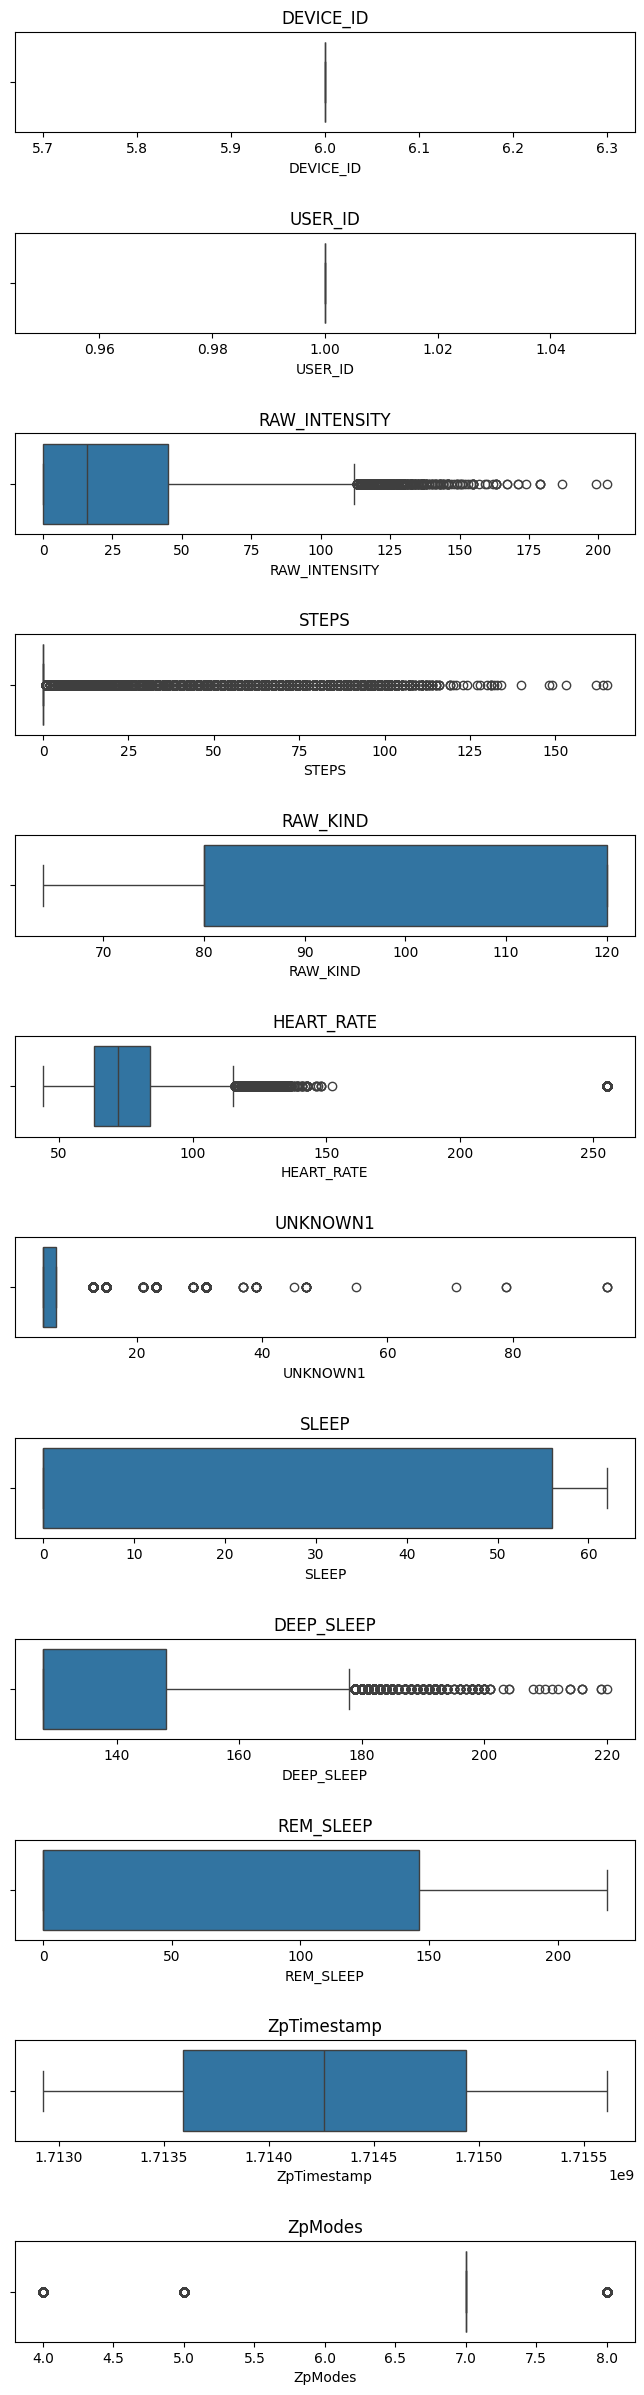

In [ ]:
# Generar gráficas individuales pues las variables numéricas
# están en rangos diferentes
cols_num = ['DEVICE_ID', 'USER_ID', 'RAW_INTENSITY', 'STEPS', 'RAW_KIND',
            'HEART_RATE', 'UNKNOWN1', 'SLEEP', 'DEEP_SLEEP', 'REM_SLEEP',
            'ZpTimestamp', 'ZpModes']

fig, ax = plt.subplots(nrows=12, ncols=1, figsize=(8,30))
fig.subplots_adjust(hspace=1)

for i, col in enumerate(cols_num):
    sns.boxplot(x=col, data=device6_c, ax=ax[i])
    ax[i].set_title(col)

In [ ]:
# Eliminar valores atípicos donde la variable "HEART_RATE" sea mayor de 230
print(f'Tamaño del set antes de eliminar registros de frecuencia: {device6_c.shape}')
print(f'Tamaño del set antes de eliminar registros de frecuencia: {device7_c.shape}')
print(f'Tamaño del set antes de eliminar registros de frecuencia: {device8_c.shape}')

device6_c = device6_c[device6_c["HEART_RATE"] <= 230]
device7_c = device7_c[device7_c["HEART_RATE"] <= 230]
device8_c = device8_c[device8_c["HEART_RATE"] <= 230]

print(f'Tamaño del set después de eliminar registros de frecuencia: {device6_c.shape}')
print(f'Tamaño del set después de eliminar registros de frecuencia: {device7_c.shape}')
print(f'Tamaño del set después de eliminar registros de frecuencia: {device8_c.shape}')


Tamaño del set antes de eliminar registros de frecuencia: (44550, 16)
Tamaño del set antes de eliminar registros de frecuencia: (45961, 16)
Tamaño del set antes de eliminar registros de frecuencia: (52101, 16)
Tamaño del set después de eliminar registros de frecuencia: (43163, 16)
Tamaño del set después de eliminar registros de frecuencia: (37030, 16)
Tamaño del set después de eliminar registros de frecuencia: (50518, 16)


2.   Eliminar valores faltantes

No tenemos filas estén vacías pero si que periodos con datos "raros"

In [ ]:
# Del 12 al 19 de abril no se mide el sueño en el device 7, todo el rato pone que está despierto, por lo que habria que borrarlos
print(f'Tamaño del set antes de eliminar registros de frecuencia: {device7_c.shape}')

# Periodo de tiempo que se va a eliminar
start_date = "2022-04-12"
end_date = "2022-04-19"

device7_c = device7_c[~((device7_c['DATETIME'] >= start_date) & (device7_c['DATETIME'] <= end_date))]

print(device7_c.head())
print(f'Tamaño del set despues de eliminar registros de frecuencia: {device7_c.shape}')


Tamaño del set antes de eliminar registros de frecuencia: (37030, 16)
              DATETIME   TIMESTAMP  DEVICE_ID  USER_ID  RAW_INTENSITY  STEPS  \
4  2024-04-12 20:41:00  1712947260          7        1             12      0   
14 2024-04-12 20:51:00  1712947860          7        1             23      0   
24 2024-04-12 21:01:00  1712948460          7        1             41      0   
34 2024-04-12 21:11:00  1712949060          7        1             18      0   
44 2024-04-12 21:21:00  1712949660          7        1             26      0   

    RAW_KIND  HEART_RATE  UNKNOWN1  SLEEP  DEEP_SLEEP  REM_SLEEP  ZpTimestamp  \
4         80          66         5      0         128          0   1712947260   
14        80          63         5      0         128          0   1712947860   
24        96          71         5      0         128          0   1712948460   
34        80          73         5      0         128          0   1712949060   
44        80          67         5      0   

3. Columnas irrelevantes

Tenemos columnas que no aportan informacion relevante o incluso que nos aportan informacion redundante. Por lo que para que la red no tenga informacion innecesaria, se proceden a eliminar una vez tengamos claro las variables queremos seleccionar para la red.

# Análsis exploratorio de las variables


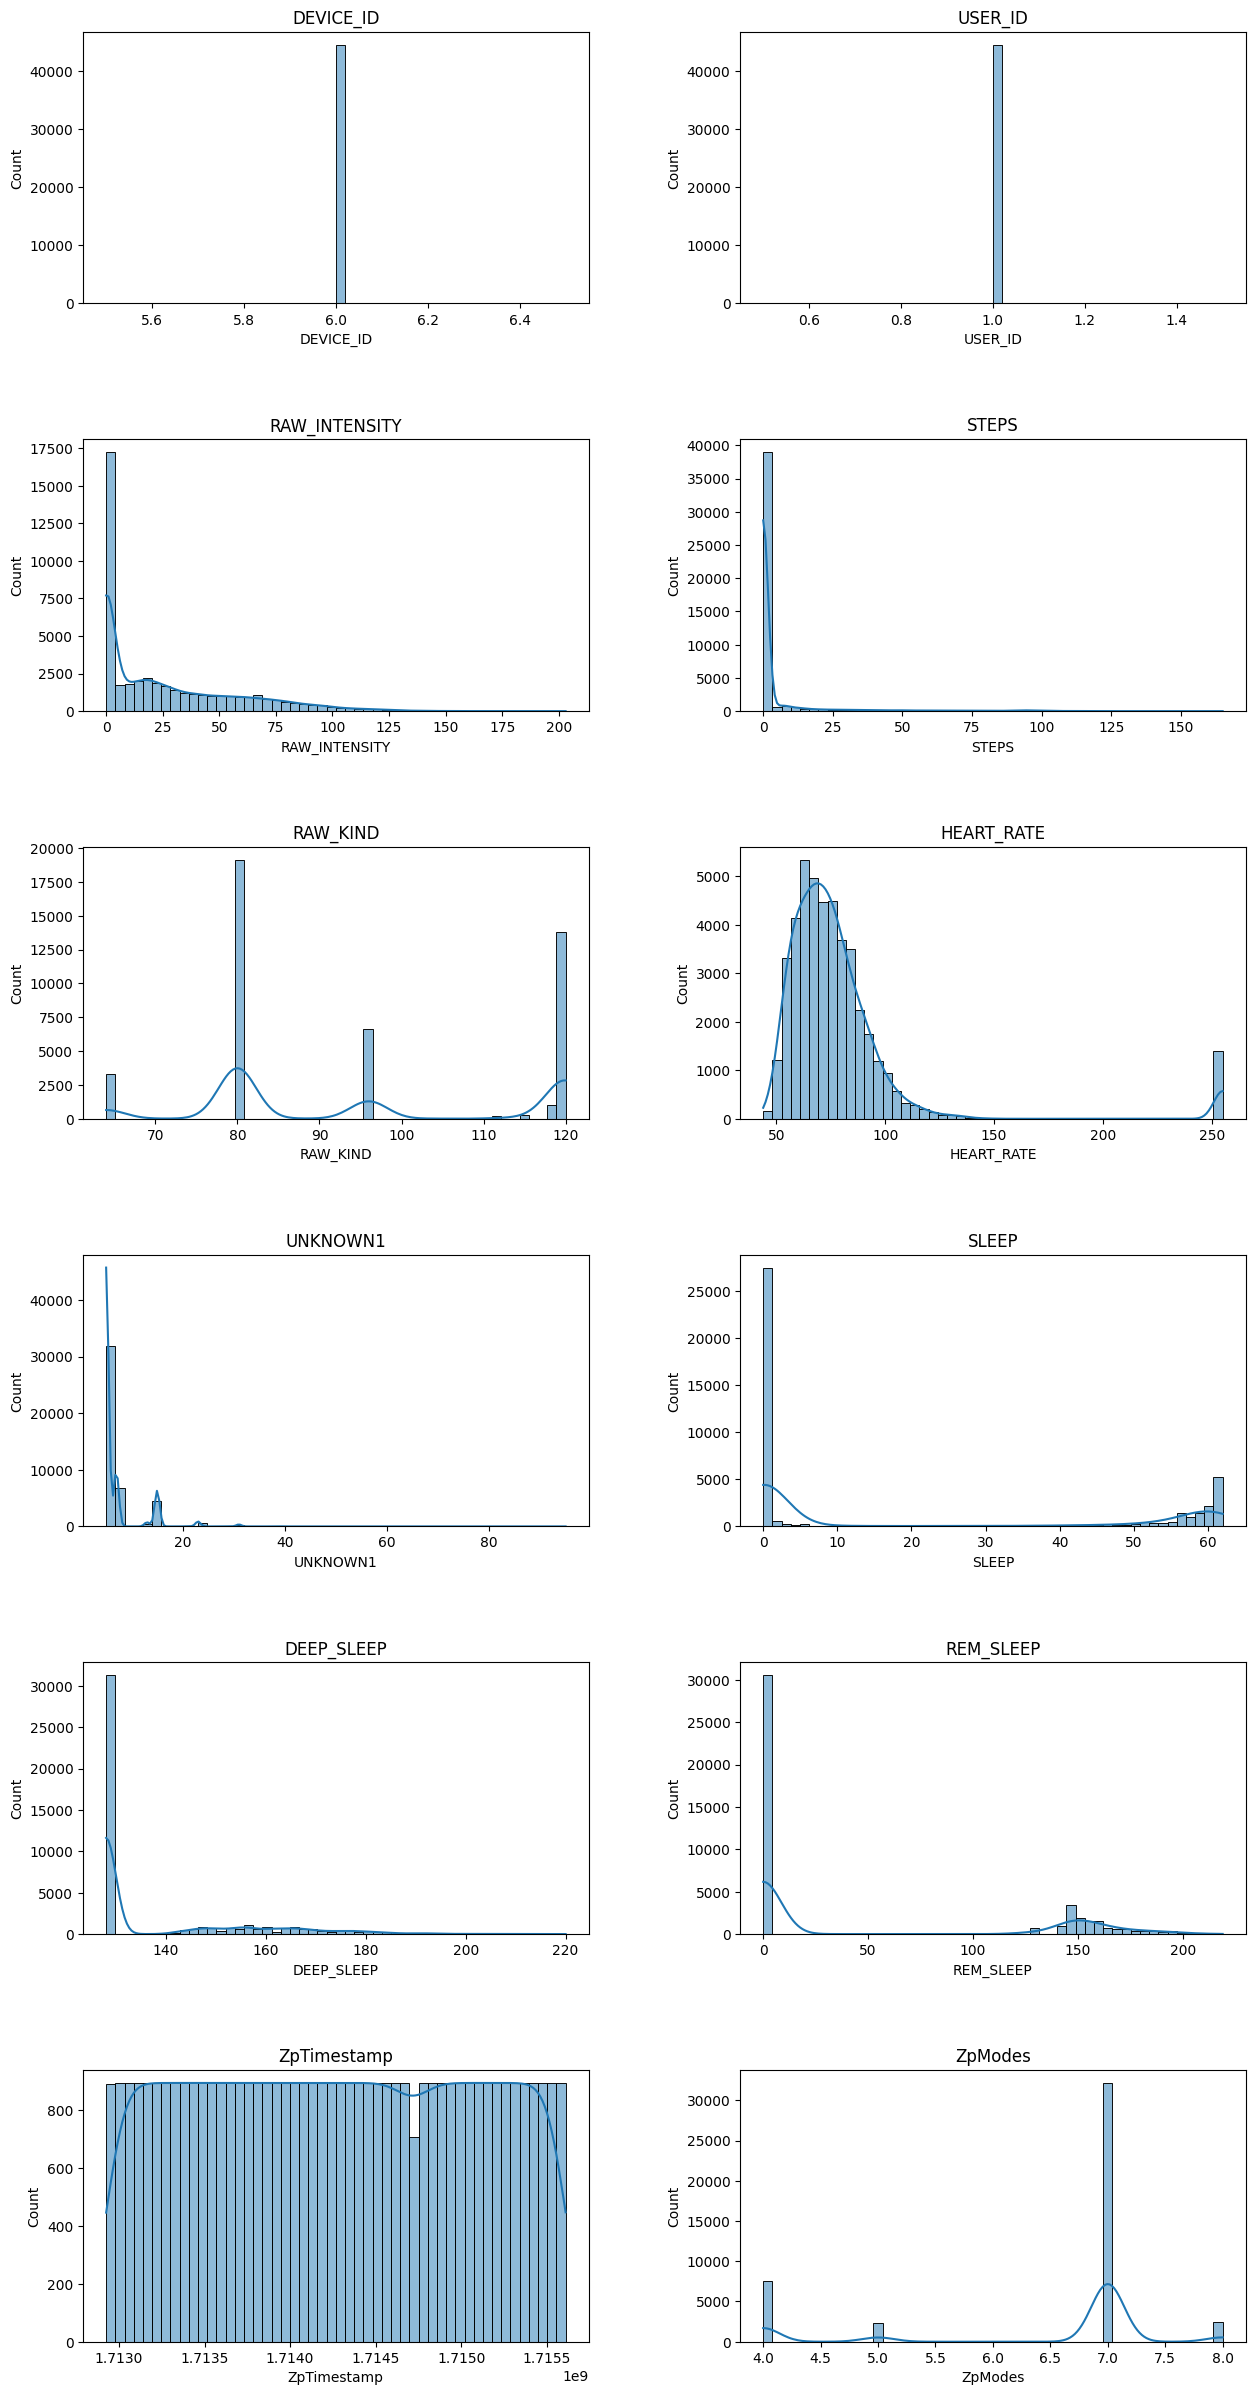

In [14]:
# Lista de columnas a graficar
col_num = ['DEVICE_ID', 'USER_ID', 'RAW_INTENSITY', 'STEPS', 'RAW_KIND',
           'HEART_RATE', 'UNKNOWN1', 'SLEEP', 'DEEP_SLEEP', 'REM_SLEEP',
           'ZpTimestamp', 'ZpModes']

# Configuración de los subplots: 6 filas y 2 columnas para 12 gráficos
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(15, 30))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# Aplanar el array de ejes para facilitar la iteración
ax = ax.flatten()

# Crear histogramas para cada columna
for i, col in enumerate(col_num):
    if col == 'age':
        nbins = 10
    else:
        nbins = 50
    sns.histplot(x=col, data=device6_c, ax=ax[i], bins=nbins, kde=True)
    ax[i].set_title(col)

# Mostrar la figura
plt.show()


Observaciones:


*   Vemos que las variables "DEVICE_ID" y "USER_ID" tienen un único valor ya que corresponde con el usuario de la pulsera wearable.
*   Las variables "RAW_INTENSITY" y "STEPS" tienen valores relativamente bajos.
*   La variable "RAW_KIND" muestra que toma más veces una serie de determinados valores que indica que las actividades realizadas serán repetidas pero no sabemos cuales pueden ser.
*   La variable "HEAR_RATE" tomas valores atípicos en 255, que sabemos que son errores de medición de la pulsera.
*   La variable ZpModes nos indica que hay muchas de muestras de una clase de sueño y de las demás hay poca representación por lo que las clases están desbalanceadas.

Ya tenemos un mapa mental de nuestros datos, y vemos en los rangos en los que se mueven.

# Matriz de correlación

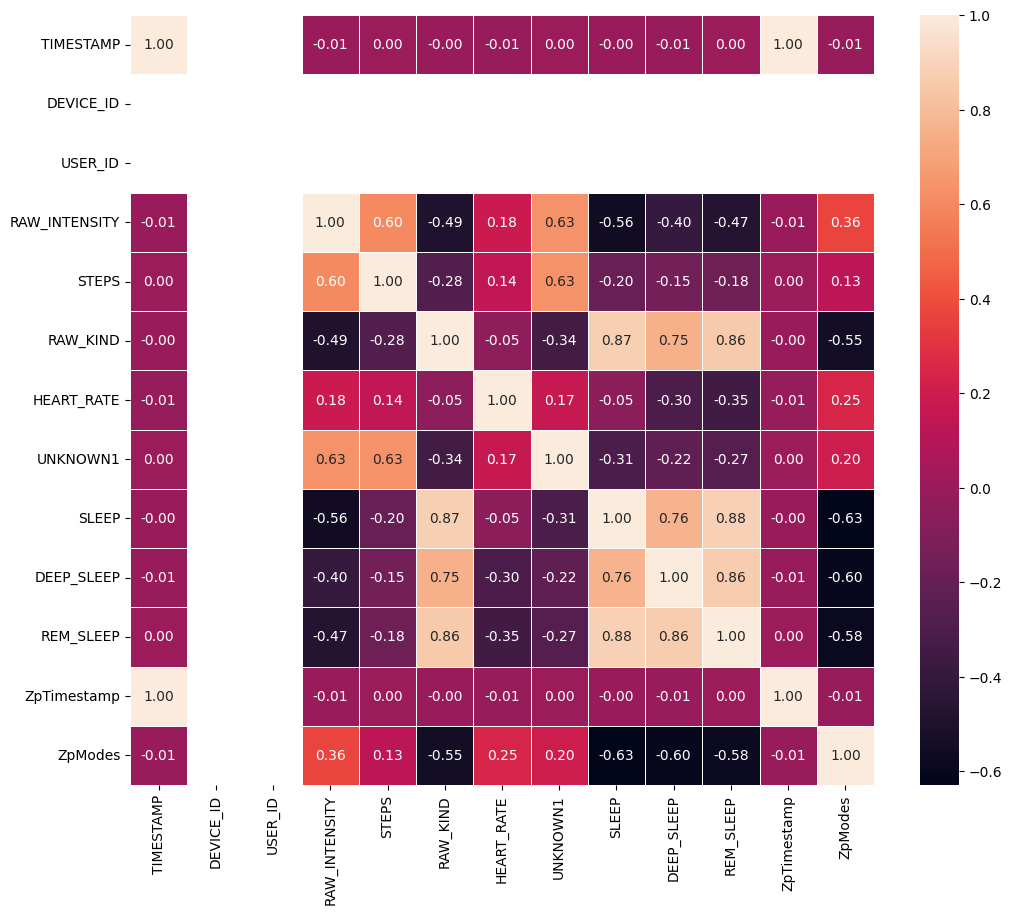

In [ ]:
num_cols=device6_c.select_dtypes(include='number').columns

matriz=device6_c[num_cols].corr() # coeficiente de Pearson
plt.figure(figsize=(12, 10))

sns.heatmap(matriz,annot=True, linewidths=0.5, fmt=".2f")

# Mostrar la figura
plt.show()

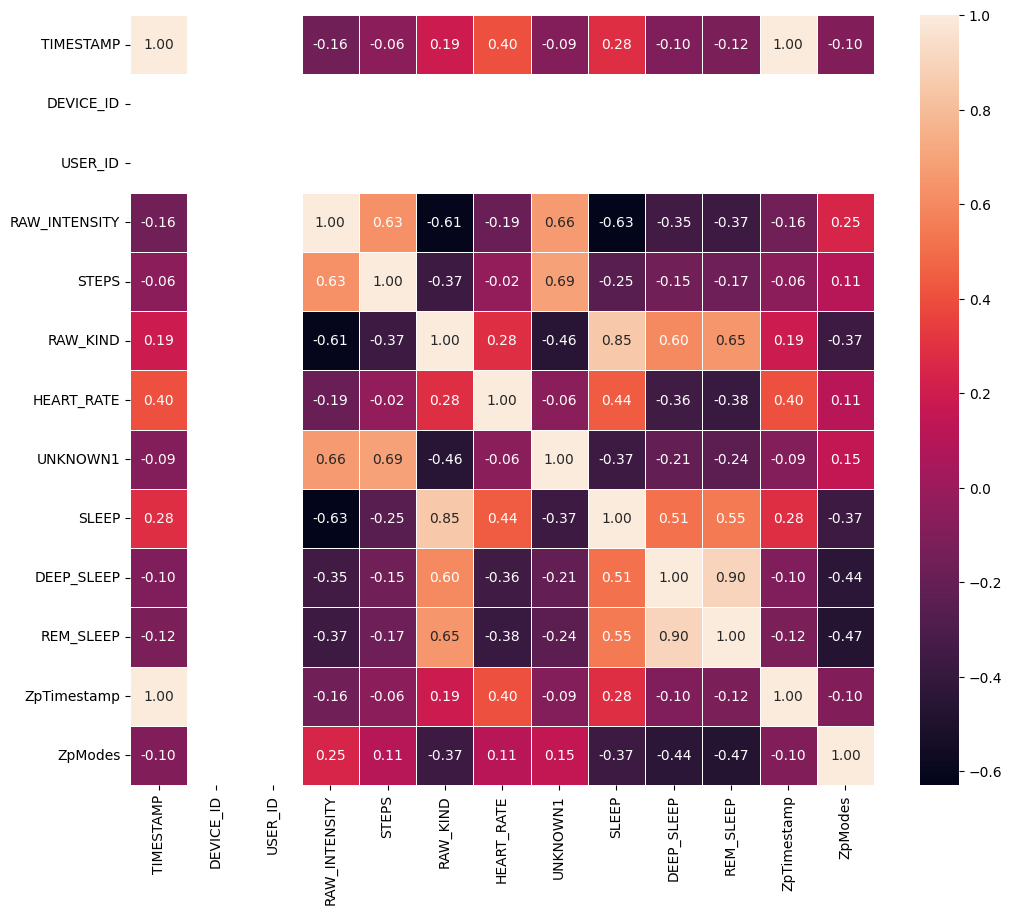

In [ ]:
num_cols=device7_c.select_dtypes(include='number').columns

matriz=device7_c[num_cols].corr() # coeficiente de Pearson
plt.figure(figsize=(12, 10))

sns.heatmap(matriz,annot=True, linewidths=0.5, fmt=".2f")

# Mostrar la figura
plt.show()

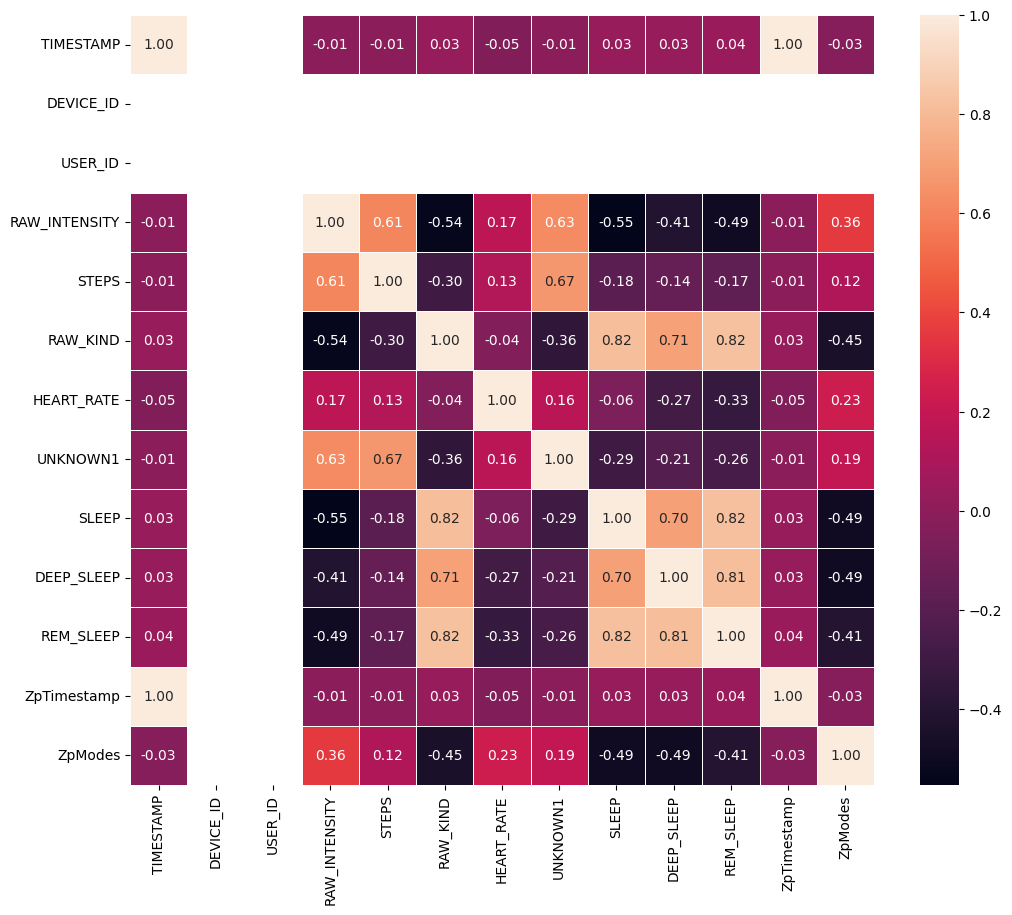

In [ ]:
num_cols=device8_c.select_dtypes(include='number').columns

matriz=device8[num_cols].corr() # coeficiente de Pearson
plt.figure(figsize=(12, 10))

sns.heatmap(matriz,annot=True, linewidths=0.5, fmt=".2f")

# Mostrar la figura
plt.show()

Observaciones:


*   Las variables "DEVICE_ID" y "USER_ID" quedan descartadas ya que no aportan información relevante.
*   Las variables "SLEEP", "UNKNOWN1", "DEEP_SLEEP" y "REM_SLEEP" son números codificados por lo que quedan descartadas.
*   Las variables "Timestamp" y "ZpTimestamp" también quedan descartadas para no tener la variable tiempo.
*   La variable "ZpModes" contiene las etiquetas y es la variable a predecir.



# Desbalanceo de clases

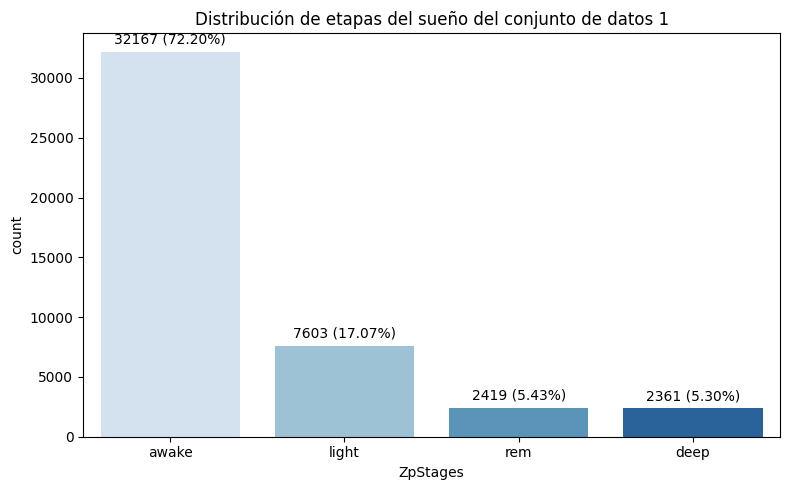

In [50]:
# Contar valores y calcular porcentaje
counts = device6_c['ZpStages'].value_counts()
total = len(device6_c)
df = counts.reset_index()
df.columns = ['ZpStages', 'count']
df['percent'] = df['count'] / total * 100

# Crear gráfico
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x='ZpStages',
    y='count',
    data=df,
    hue='ZpStages',
    dodge=False,
    palette=sns.color_palette("Blues", n_colors=len(df))
)

# Añadir etiquetas: conteo + porcentaje
for index, row in df.iterrows():
    label = f"{row['count']} ({row['percent']:.2f}%)"
    ax.text(index, row['count'] + total * 0.01, label, ha='center', va='bottom')

plt.title('Distribución de etapas del sueño del conjunto de datos 1')
plt.tight_layout()
plt.show()


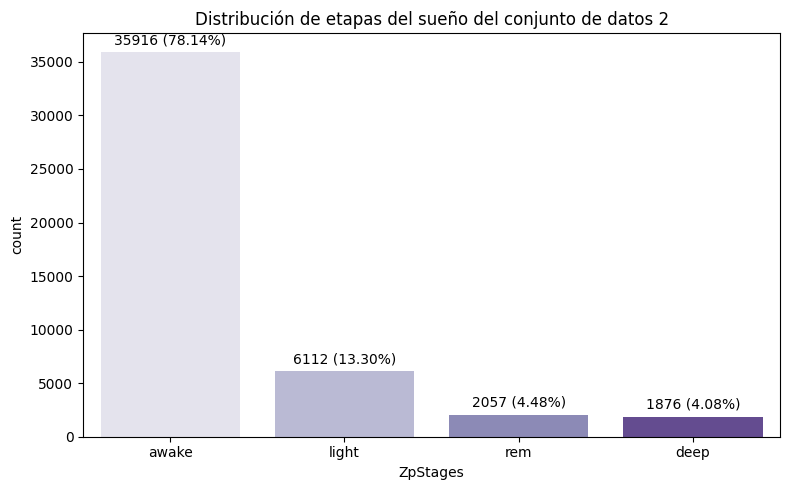

In [49]:
# Contar valores y calcular porcentaje
counts = device7_c['ZpStages'].value_counts()
total = len(device7_c)
df = counts.reset_index()
df.columns = ['ZpStages', 'count']
df['percent'] = df['count'] / total * 100

# Crear gráfico
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x='ZpStages',
    y='count',
    data=df,
    hue='ZpStages',
    dodge=False,
    palette=sns.color_palette("Purples", n_colors=len(df))
)

# Añadir etiquetas: conteo + porcentaje
for index, row in df.iterrows():
    label = f"{row['count']} ({row['percent']:.2f}%)"
    ax.text(index, row['count'] + total * 0.01, label, ha='center', va='bottom')

plt.title('Distribución de etapas del sueño del conjunto de datos 2')
plt.tight_layout()
plt.show()


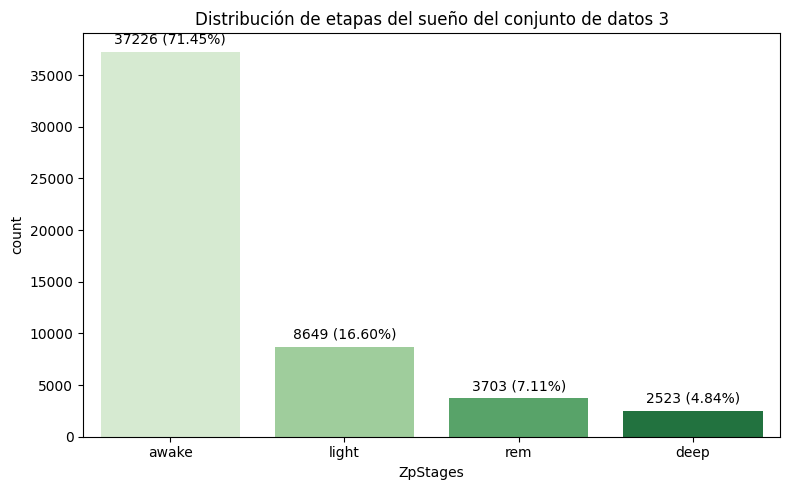

In [48]:
# Contar valores y calcular porcentaje
counts = device8_c['ZpStages'].value_counts()
total = len(device8_c)
df = counts.reset_index()
df.columns = ['ZpStages', 'count']
df['percent'] = df['count'] / total * 100

# Crear gráfico
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x='ZpStages',
    y='count',
    data=df,
    hue='ZpStages',
    dodge=False,
    palette=sns.color_palette("Greens", n_colors=len(df))
)

# Añadir etiquetas: conteo + porcentaje
for index, row in df.iterrows():
    label = f"{row['count']} ({row['percent']:.2f}%)"
    ax.text(index, row['count'] + total * 0.01, label, ha='center', va='bottom')

plt.title('Distribución de etapas del sueño del conjunto de datos 3')
plt.tight_layout()
plt.show()
